# Part 3: Data Exploration

#### Author: Ali Eddeb

Some data exploration was performed in the previous notebook that helped guide feature engineering. We will continue exploring the data in this notebook to gain further insights into the data.

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import library that contains functions that read in, clean and perform feature engineering on the data
import functions_library as fl

In [4]:
#let's bring in the beauty review dataset with the cleaning and feature engineering steps applied
df = fl.pipedf('All_Beauty.json.gz')

In [5]:
df.tail()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,vote,review_word_count,summary_word_count,month,dayofweek,multipleReviews_reviewer,reviewer_five_star_only,reviewer_one_star_only,numReviews_product,nameProvided
362247,1,1,2017-07-20,A202DCI7TV1022,B01HJEGTYK,Sam,It was awful. It was super frizzy and I tried ...,It was super frizzy and I tried to comb it and...,0,28,13,7,3,0,0,1,10,1
362248,5,1,2017-03-16,A3FSOR5IJOFIBE,B01HJEGTYK,TYW,I was skeptical about buying this. Worried it...,Awesome,34,43,1,3,3,0,1,0,10,1
362249,5,1,2017-03-01,A1B5DK6CTP2P24,B01HJEGTYK,Norma Jennings,Makes me look good fast.,Five Stars,46,5,2,3,2,0,1,0,10,1
362250,2,1,2017-02-21,A23OUYS5IRMJS9,B01HJEGTYK,Lee,Way lighter than photo\nNot mix blend of color...,Ok but color way off and volume as well,0,28,9,2,1,0,0,0,10,1
362251,2,1,2016-12-15,A24KQ9RVU81L87,B01HJEGTYK,Season341,No return instructions/phone # in packaging. ...,Might return for a replacement if I could.,0,32,8,12,3,1,0,0,10,1


## Data Exploration

### 1. Distributions

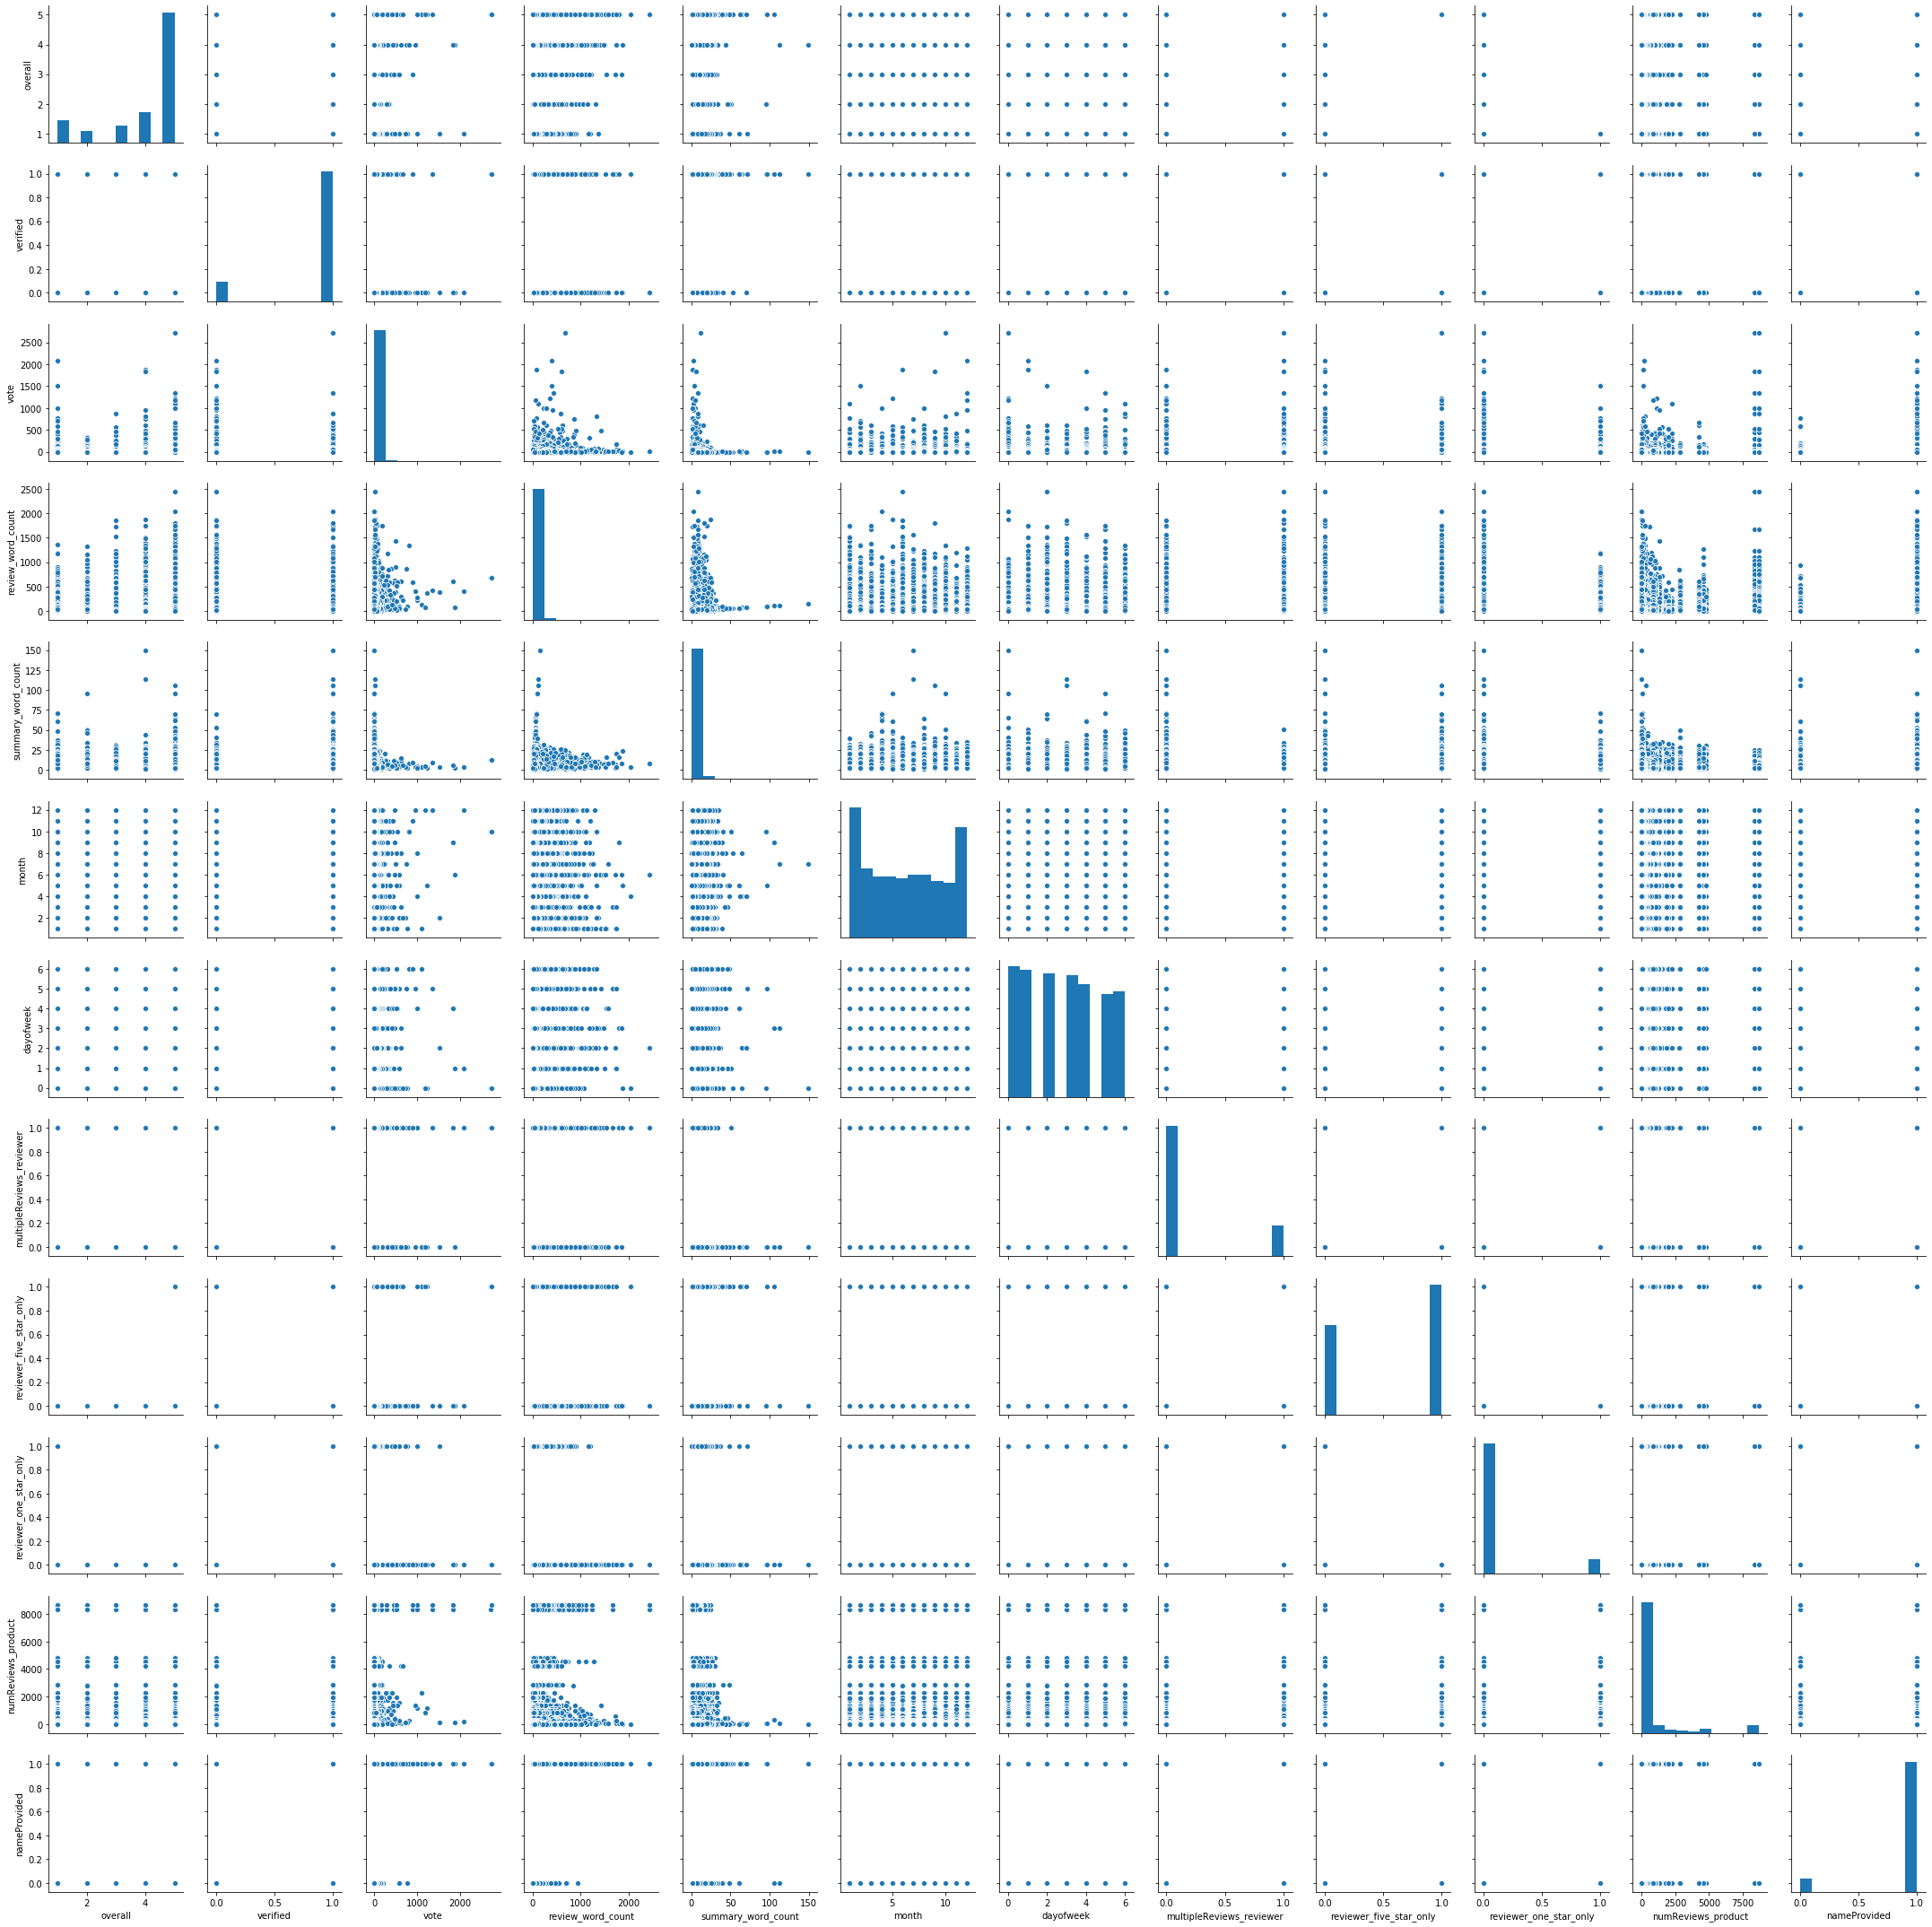

In [23]:
#let's start by visualizing all the distributions of the numeric features
plt.figure()
sns.pairplot(df)
plt.show()

Off the bat, we can see that the distributions within each feature are heavily skewed. Let's hone in on some of the most important features: overall, verified and votes.

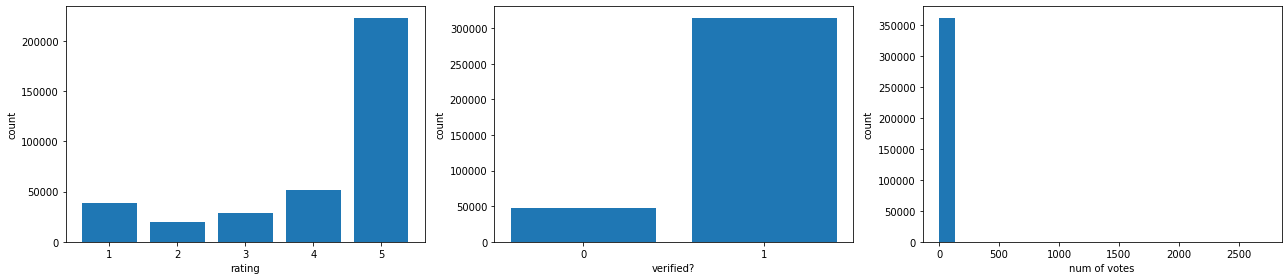

In [30]:
#let's look at the distributions of ratings, verified purchases, and helpful votes.
plt.subplots(1,3, figsize=(18,4))

plt.subplot(1,3,1)
plt.bar(df['overall'].value_counts().index, df['overall'].value_counts().values)
plt.xlabel('rating')
plt.ylabel('count')

plt.subplot(1,3,2)
plt.bar(df['verified'].value_counts().index, df['verified'].value_counts().values)
plt.xlabel('verified?')
plt.ylabel('count')
plt.xticks(range(0,2))

plt.subplot(1,3,3)
plt.hist(df['vote'], bins=20)
plt.xlabel('num of votes')
plt.ylabel('count')

plt.tight_layout()
plt.show()

From the above graphs, we can see these features are heavily skewed. Reviews are skewed to:
- 5 star ratings
- verified purchases
- low number of helpful votes

Although there are heavy class imbalances, I am not building a model to predict certain outcome(s). Rather I will be clustering the reviews and exploring cluster features to try and find fake reviews. Dealing with class imbalances may be something I look into more in a future iteration of this project.

Next, how many reviews, products and reviewers are in the beauty dataset?

In [6]:
#reviews, products, reviewers
print(f'Reviews: {len(df)}')
print(f'Products: {len(df["asin"].value_counts())}') 
print(f'Reviewers: {len(df["reviewerID"].value_counts())}')

Reviews: 362252
Products: 32571
Reviewers: 323687


There are 10 times the number of reviews compared to the number of products. Number of reviewers is closer to the number of reviews and as we have seen in the previous notebook, approximately 90% of reviewers only post 1 review which explains why there are almost as many reviewers as reviews.
However, let's focus on the reviews per product as we have not explored this yet.

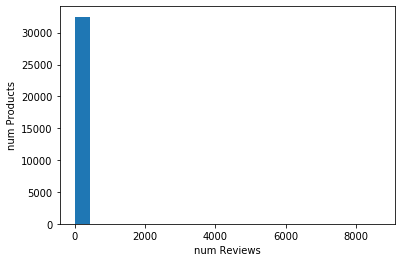

In [8]:
#distribution of number of reviews per product
plt.figure()
plt.hist(df['asin'].value_counts().values, bins=20)
plt.xlabel('num Reviews')
plt.ylabel('num Products')
plt.show()

Quite evidently, the distribution is heavily skewed to low values.


So what we can figure out from this is most products have very few reviews.

In [10]:
np.quantile(df['asin'].value_counts().values, np.arange(0,1.05,0.05)).astype(int)

array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    2,    2,
          2,    3,    3,    4,    5,    7,   10,   16,   34, 8670])

Now it's very clear from seeing the quantiles. Up until the 85th percentile, products have still not surpassed more than 10 reviews.

### 2. Temporal trends
Let's explore if there were any trends over time in the data.

##### Is there a trend between year and number of verified purchases?

In [15]:
#creating a dataframe that has the number of reviews per year, but segmented by whether or not the review was associated with a verified purchase
verified_year = df['verified'].groupby(df['reviewTime'].dt.year).value_counts()
verified_year = verified_year.reset_index(level='reviewTime').rename(columns={'verified':'numReviews'}).reset_index()
verified_year.head()

,verified,reviewTime,numReviews
0,0,2000,13
1,0,2001,51
2,1,2001,15
3,0,2002,63
4,1,2002,15


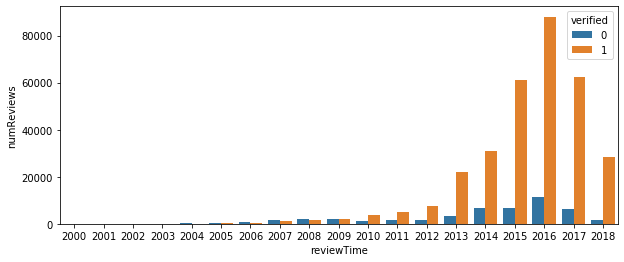

In [16]:
#plotting number of reviews per year (segmented by verified purchases)
plt.figure(figsize=(10,4))
sns.barplot(x='reviewTime', y='numReviews', hue='verified', data=verified_year)
plt.show()

As we can see from the graph, pre-2009, the number of verified purchases were less than the number of unverified purchases annually. However, this changed after 2009 - the proportion of reviews with verified purchases overtook the proportion of reviews with unverified purchases. Seemingly, Amazon has put up barriers on submitting reviews without a verified purchase which should help to decrease the number of fake reviews. Nonetheless, there may be businesses incentivizing people to post good reviews in exchange for their product and this may a new way businesses are able to get fake good reviews. We should revisit this when performing cluster analysis later in the project. However, this does make it more difficult for competitors to post bad reviews as this would entail purchasing their competitor's product! Thus, I surmise that we might see more of the first case (fake good reviews).

Please proceed to the next notebook in which the data is prepared for modelling.